In [1]:
import os
import pandas as pd
from tqdm import tqdm
tqdm.pandas()
import pickle
from sklearn.metrics import f1_score, classification_report
from sklearn.dummy import DummyClassifier
import torch
from transformers import AdamW, BertTokenizer, BertForSequenceClassification
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
PREFIX = "../../data/"
PA_PATH = PREFIX + "sap2017-connotation-frames-power-agency/"
TT_PATH = PA_PATH + "train-test-splits/"
MODEL_PATH = 'power_bert_context_models_v3/'

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('device', device)

device cuda


# test set

In [5]:
with open(TT_PATH + 'test_power_vp.pickle', 'rb') as f:
    test_vp = pickle.load(f)

In [6]:
pa = pd.read_pickle(PA_PATH + 'power_agency_sents.pkl')
pa = pa[pa.verb_prep.isin(test_vp)]

In [7]:
MASK = '<VERB>'
SEP = '<SEPX>'
def get_mask_w_context(row):
    result = []
    for sent in row.sents:
        string = sent.to_plain_string()
        found = False

        for token in sent:
            if not found and token.get_tag('lemma').value == row.lemma:
                string = token.text + ' ' + SEP + ' ' + string.replace(token.text, MASK) 
                found = True
        result.append(string)
    return result

In [8]:
pa['sents_masked'] = pa.progress_apply(get_mask_w_context, axis=1)

100%|██████████| 340/340 [00:05<00:00, 67.55it/s]


In [9]:
pa = pa.drop('index',axis=1)
pa.reset_index(inplace=True)

In [10]:
X = pa.sents_masked
y = pa.power.map({'power_agent': 0, 'power_equal': 1, 'power_theme': 2 })

In [11]:
len(X), len(y)

(340, 340)

In [12]:
y.value_counts()

0    237
1     65
2     38
Name: power, dtype: int64

In [13]:
Xy = pd.concat([X, y], axis=1)

In [14]:
Xy = Xy.explode('sents_masked')

In [15]:
X = Xy['sents_masked']
y = Xy['power']

In [16]:
len(X), len(y)

(68000, 68000)

## get model

In [17]:
def read_model(save_dir):
    model = BertForSequenceClassification.from_pretrained(save_dir, num_labels=3)
    model.to(device)
    return model

In [18]:
def pred(model, X, batch_size):
    predictions = []
    i1 = 0
    i2 = batch_size
    while i1 < len(X):
        sequences = X[i1:i2]
        batch = tokenizer(sequences, padding=True, truncation=True, return_tensors="pt")
        with torch.no_grad():
            outputs = model(**batch.to(device))        
        logits = outputs.logits
        predictions.extend(torch.argmax(logits, dim=-1).cpu().tolist())

        i1 += batch_size
        i2 += batch_size
        if i2 > len(X):
            i2 = len(X)    
    return predictions

In [19]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
num_added_tokens = tokenizer.add_special_tokens({
    'additional_special_tokens': [MASK, SEP]
})

In [20]:
path = 'power_bert_context_models_v3/bert-base-uncased 12 20 1e-08'

In [21]:
model = read_model(path)
model.eval()
preds = pred(model, X.tolist(), 250)

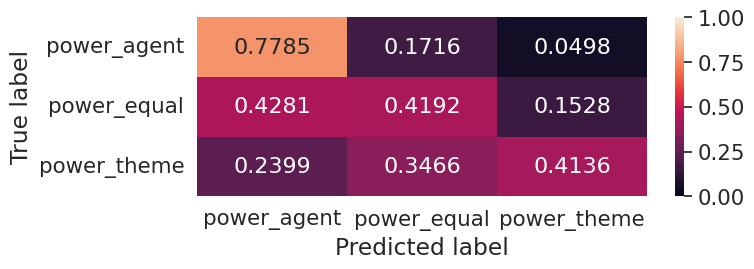

In [22]:
cm_arr = confusion_matrix(y.tolist(), preds, normalize='true')
df_cm = pd.DataFrame(cm_arr, range(3), range(3))
df_cm.columns=['power_agent', 'power_equal', 'power_theme']
df_cm.index=['power_agent', 'power_equal', 'power_theme']

plt.figure(figsize=(8,3))
sns.set(font_scale=1.4) # for label size
sns_plot = sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='.4f', vmin=0, vmax=1) 
plt.ylabel('True label', )
plt.xlabel('Predicted label')
plt.tight_layout()
sns_plot.figure.savefig('confusion_mtx/' + path.split('/')[1] + ".png", bbox_inches='tight', dpi=900)
plt.show()

# dummy

In [23]:
with open(TT_PATH + 'train_power_vp.pickle', 'rb') as f:
    train_vp = pickle.load(f)

In [24]:
pa_train = pd.read_pickle(PA_PATH + 'power_agency_sents.pkl')
pa_train = pa_train[pa_train.verb_prep.isin(train_vp)]

In [25]:
pae_train = pa_train.explode('sents')

{'power_agent': {'precision': 0.6970588235294117, 'recall': 1.0, 'f1-score': 0.8214904679376083, 'support': 47400}, 'power_equal': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 13000}, 'power_theme': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 7600}, 'accuracy': 0.6970588235294117, 'macro avg': {'precision': 0.23235294117647057, 'recall': 0.3333333333333333, 'f1-score': 0.27383015597920274, 'support': 68000}, 'weighted avg': {'precision': 0.48589100346020764, 'recall': 0.6970588235294117, 'f1-score': 0.5726271791212152, 'support': 68000}}


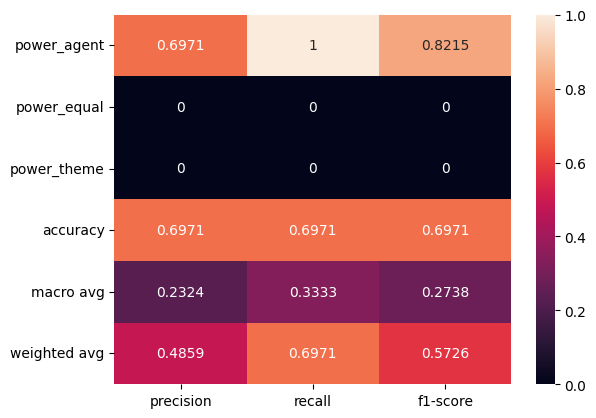

In [26]:
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(pae_train.sents, pae_train.power.map({'power_agent': 0, 'power_equal': 1, 'power_theme': 2 }))
preds = dummy_clf.predict(X.tolist())

clf_report = classification_report(y.tolist(),
                                   preds,
                                   labels=[0,1,2],
                                   target_names=['power_agent', 'power_equal', 'power_theme'],
                                   output_dict=True,
                                   digits=4)
print(clf_report)
sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True, vmin=0, vmax=1, fmt='.4g')
plt.show()